In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

csv_path = "/content/BTCtest1.csv"

df = pd.read_csv(csv_path)
print(df)

                     Date   BTCUSDT
0     2020-02-15 08:00:00  10333.09
1     2020-02-15 09:00:00  10244.50
2     2020-02-15 10:00:00  10240.64
3     2020-02-15 11:00:00  10272.39
4     2020-02-15 12:00:00  10260.63
...                   ...       ...
2516  2020-05-30 04:00:00   9420.93
2517  2020-05-30 05:00:00   9396.58
2518  2020-05-30 06:00:00   9428.26
2519  2020-05-30 07:00:00   9427.07
2520  2020-05-30 08:00:00   9370.14

[2521 rows x 2 columns]


Text(0, 0.5, 'Close Price (USDT)')

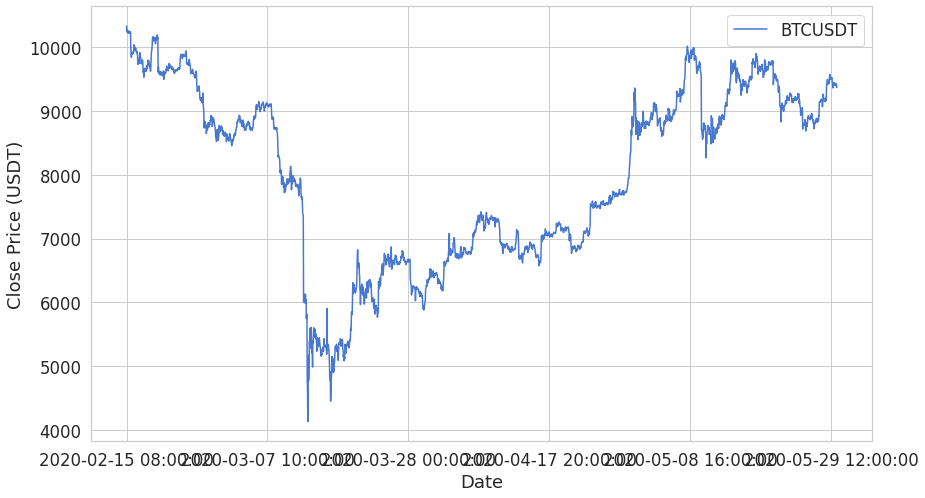

In [12]:
ax = df.plot(x='Date', y='BTCUSDT');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USDT)")

In [13]:
scaler = MinMaxScaler()

BTCUSDT_price = df.BTCUSDT.values.reshape(-1, 1)

scaled_BTCUSDT_price = scaler.fit_transform(BTCUSDT_price)

scaled_BTCUSDT_price.shape

scaled_BTCUSDT_price = scaled_BTCUSDT_price[~np.isnan(scaled_BTCUSDT_price)]

scaled_BTCUSDT_price = scaled_BTCUSDT_price.reshape(-1, 1)

np.isnan(scaled_BTCUSDT_price).any()
#　print(scaled_BTCUSDT_price)

False

In [14]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_BTCUSDT_price, SEQ_LEN, train_split = 0.95)

In [15]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [16]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
33/33 [==============================] - 5s 72ms/step - loss: 0.0523 - val_loss: 0.0041
Epoch 2/50
33/33 [==============================] - 2s 46ms/step - loss: 0.0083 - val_loss: 0.0017
Epoch 3/50
33/33 [==============================] - 2s 46ms/step - loss: 0.0099 - val_loss: 0.0057
Epoch 4/50
33/33 [==============================] - 1s 45ms/step - loss: 0.0116 - val_loss: 0.0143
Epoch 5/50
33/33 [==============================] - 1s 45ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 6/50
33/33 [==============================] - 2s 46ms/step - loss: 0.0136 - val_loss: 0.0021
Epoch 7/50
33/33 [==============================] - 1s 45ms/step - loss: 0.0159 - val_loss: 0.0227
Epoch 8/50
33/33 [==============================] - 1s 45ms/step - loss: 0.0106 - val_loss: 0.0181
Epoch 9/50
33/33 [==============================] - 1s 45ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 10/50
33/33 [==============================] - 1s 45ms/step - loss: 0.0213 - val_loss: 0.0281
Epoch 11/

4/4 [==============================] - 0s 36ms/step - loss: 4.5918e-04


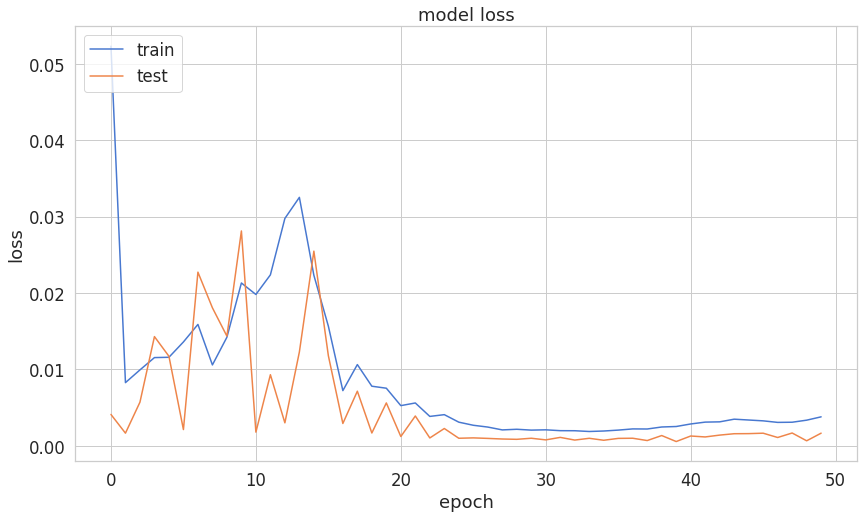

In [17]:
model.evaluate(X_test, y_test)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

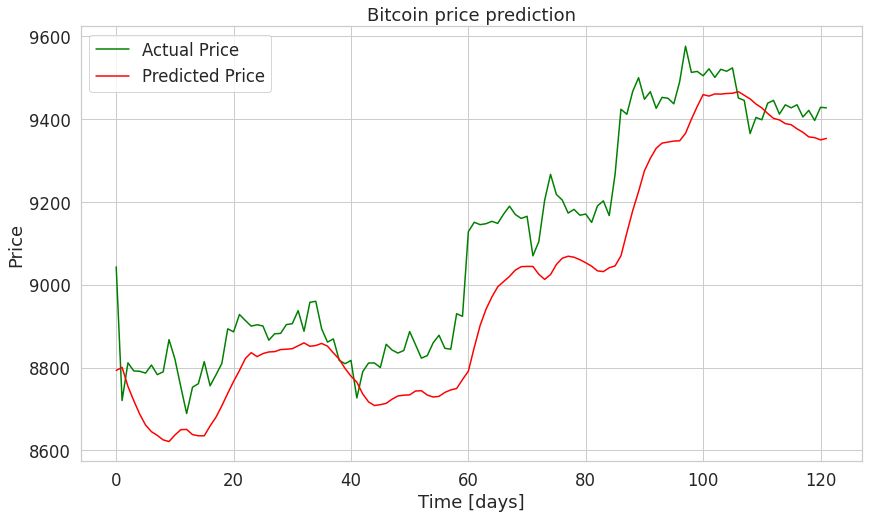

In [18]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time : hours')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();